In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json
from datetime import date, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"

#Source NL https://pageviews.wmcloud.org/?project=nl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2020-01-01&end=2020-08-31&pages=Stress|Bezorgdheid|Eenzaamheid|Slapeloosheid|Depressie_(klinisch)
#Source IT https://pageviews.wmcloud.org/?project=it.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2020-01-01&end=2020-08-31&pages=Stress|Ansia|Disturbo_depressivo|Insonnia
#Source PL https://pageviews.wmcloud.org/?project=pl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2020-01-01&end=2020-08-31&pages=L%C4%99k|Zaburzenia_depresyjne|Bezsenno%C5%9B%C4%87%7CSamotno%C5%9B%C4%87%7CStres
#Source SV LOST IT :(

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv.csv"

In [22]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

In [23]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [24]:
interventions_data.set_index('lang', inplace=True)

In [25]:
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [26]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

apple_mobility_data = apple_mobility_data.drop(columns = ['alternative_name', 'country', 'sub-region'], axis=1)

In [27]:
def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang]
    end = interventions_data['Normalcy'].loc[lang]
    if start == pd.NaT or end == pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

In [28]:
def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['month'] = df['Date'].apply(lambda date: date.month) #add month
    df['weekend'] = df['Day_of_the_week'].apply(lambda day: 1 if day == 'Saturday' or day == 'Sunday' else 0)

    df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'month', 'weekend']]
    return df

In [29]:
def get_apple_data(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return df

In [30]:
def get_google_data(lang):
    df = google_mobility_data[google_mobility_data['country_region'] == region[lang]]
    df = df[df['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
    df = df.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
    df = df.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
    df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
    del df['date']
    df = df.drop_duplicates()
    df.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline':'grocery',
                        'parks_percent_change_from_baseline':'parks',
                        'transit_stations_percent_change_from_baseline':'stations',
                        'workplaces_percent_change_from_baseline':'workplaces',
                        'residential_percent_change_from_baseline':'residential'},
                        inplace = True)
    return df

In [31]:
def merge_datasets(pageviews, apple, google):
    df = pd.merge(pageviews, apple, left_index=True, right_index=True)
    df = pd.merge(df, google, left_index=True, right_index=True)
    return df

In [32]:
LANGUAGES = ['nl', 'sv', 'pl', 'it']
#each array with have 5 elements, one for each disease
#the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'
it_reg_res = []
nl_reg_res = []
sv_reg_res = []
pl_reg_res = []

In [33]:
def regression(disease, lang, df):
    if lang == 'pl': #No transit data for poland
        mod = smf.ols(formula= disease + ' ~ driving + walking + retail + grocery + parks + stations + workplaces + residential + C(first_case) + C(first_death) + C(lockdown) + C(month) + C(weekend)', data=df)
    else:
        mod = smf.ols(formula= disease + ' ~ driving + transit + walking + retail + grocery + parks + stations + workplaces + residential + C(first_case) + C(first_death) + C(lockdown) + C(month) + C(weekend)', data=df)
    np.random.seed(2)
    res = mod.fit()
    if(lang == 'nl'):
        nl_reg_res.append(res)
    elif(lang == 'sv'):
        sv_reg_res.append(res)
    elif(lang == 'pl'):
        pl_reg_res.append(res)
    elif(lang == 'it'):
        it_reg_res.append(res)
    
    print('\n Regression for ' + disease + ' in ' + region[lang] + '\n')
    print(res.summary())

In [34]:
def loop(langs, diseases):
    for lang in langs:
        pageviews = get_pageviews_data(lang)
        apple = get_apple_data(lang)
        google = get_google_data(lang)
        df = merge_datasets(pageviews, apple, google)
        for disease in diseases:
            regression(disease, lang, df)

In [35]:
loop(LANGUAGES, diseases_names['en'])


 Regression for anxiety in Netherlands

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2.689
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           0.000477
Time:                        21:59:05   Log-Likelihood:                -519.07
No. Observations:                 191   AIC:                             1076.
Df Residuals:                     172   BIC:                             1138.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [36]:
print(pl_reg_res[0].summary())

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     28.24
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           4.65e-40
Time:                        21:59:06   Log-Likelihood:                -786.46
No. Observations:                 191   AIC:                             1607.
Df Residuals:                     174   BIC:                             1662.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             150.8738    

Now we can visualize the effect of all the predictors. Let's first sort them by the coefficients.

In [37]:
def visualise_effect_of_predictors(res, lang, disease_idx):
    # feature names
    variables = res.params.index
    # quantifying uncertainty!
    # coefficients
    coefficients = res.params.values
    # p-values
    p_values = res.pvalues
    # standard errors
    standard_errors = res.bse.values
    #confidence intervals
    res.conf_int()

    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    plt.title("Language: " + lang + ", Disease: " + diseases_names['en'][disease_idx])
    #fancy plotting
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                linestyle = 'none',marker = 'o',markersize= 3,
                markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')

    plt.yticks(range(len(l2)),l2)
    plt.show()

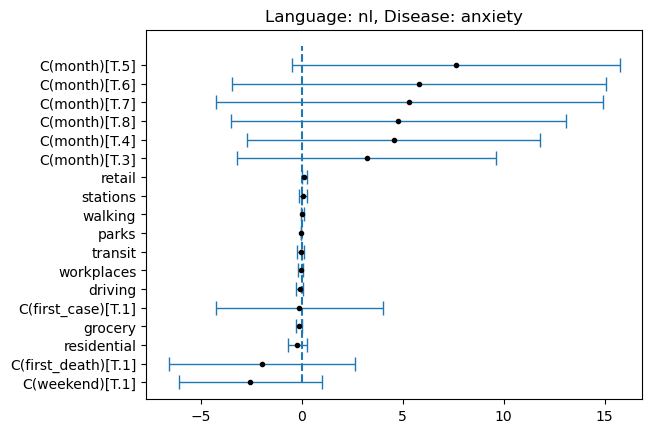

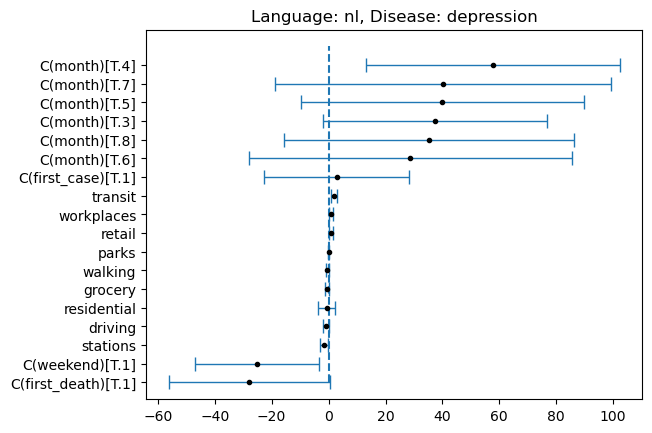

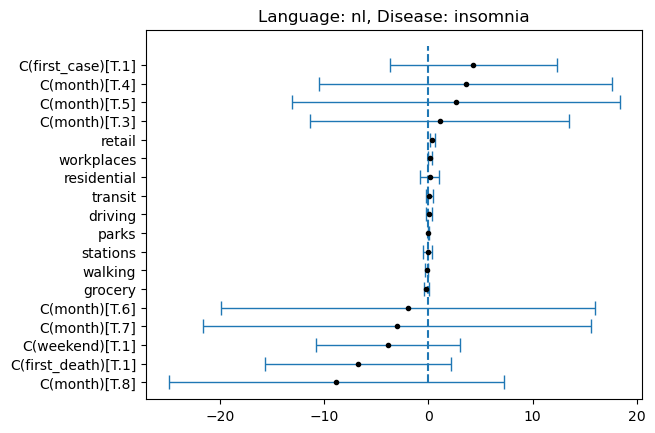

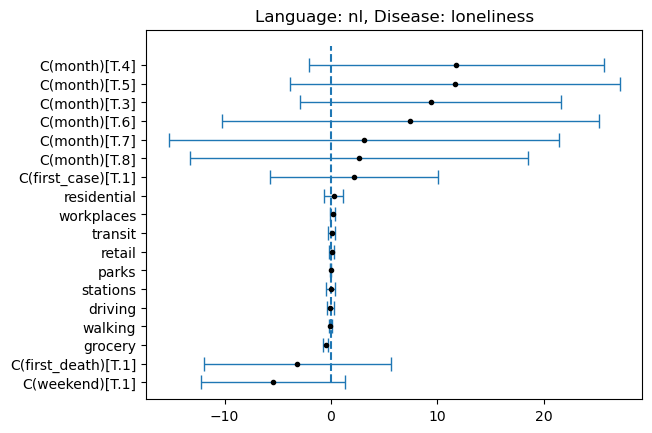

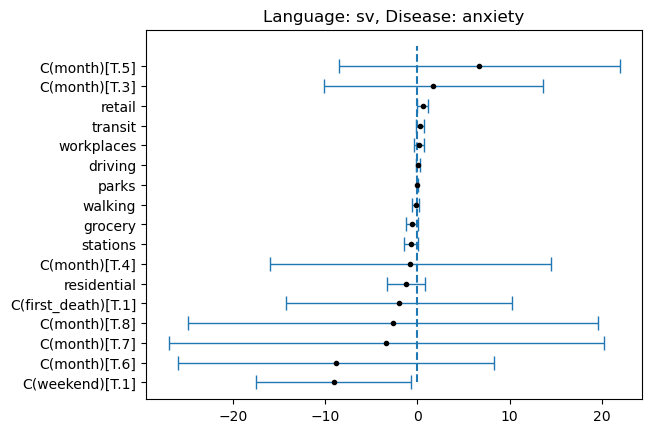

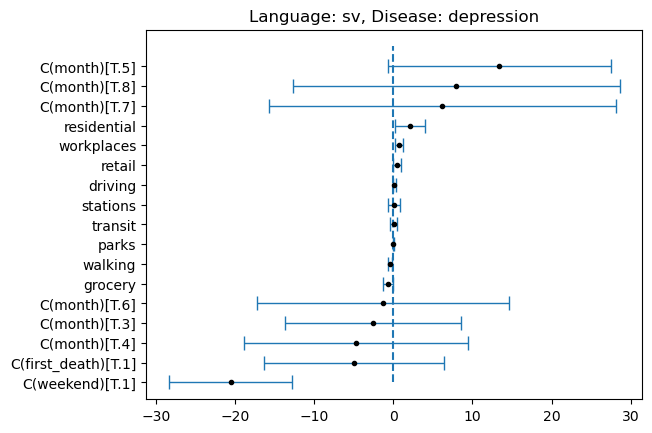

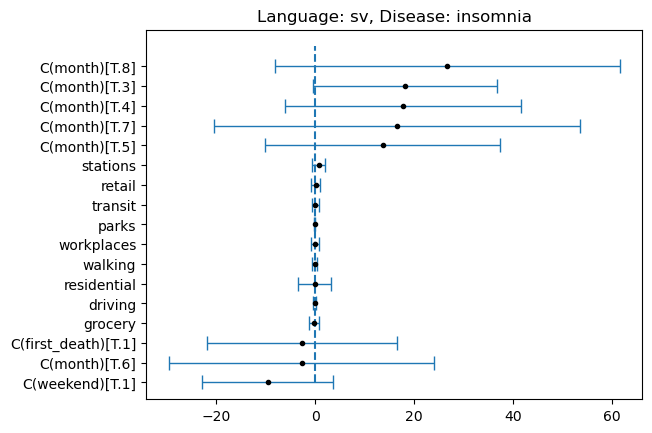

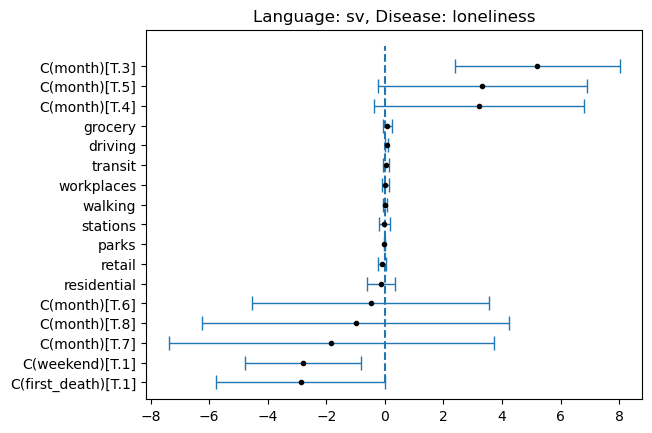

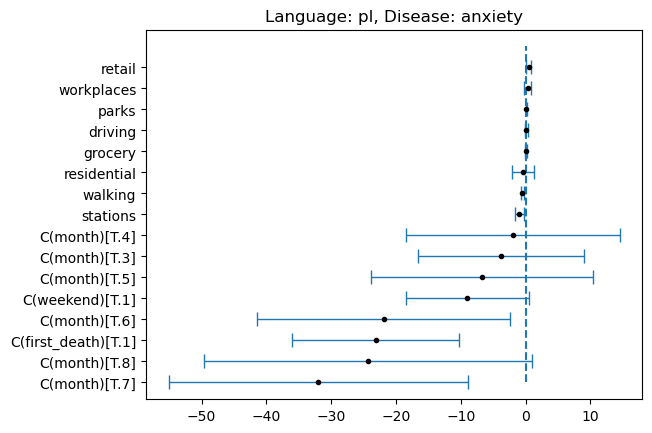

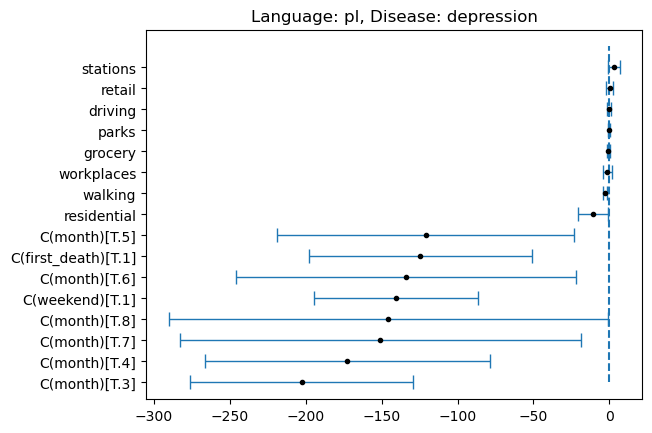

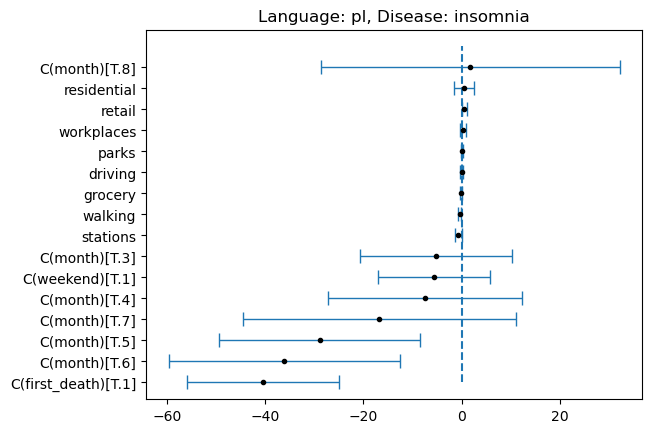

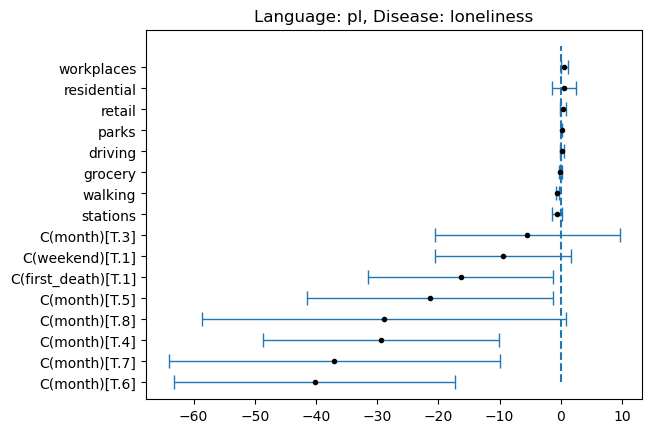

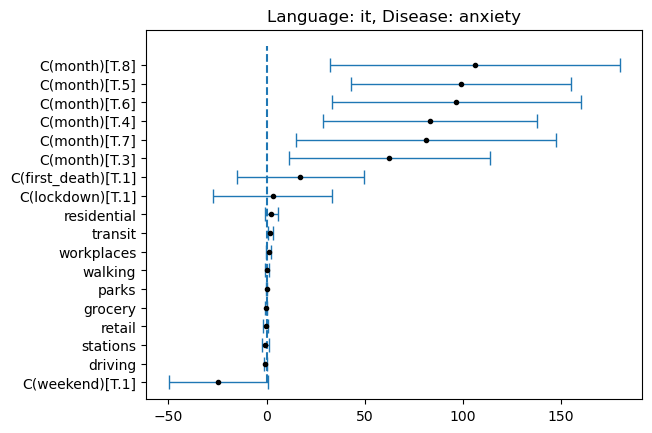

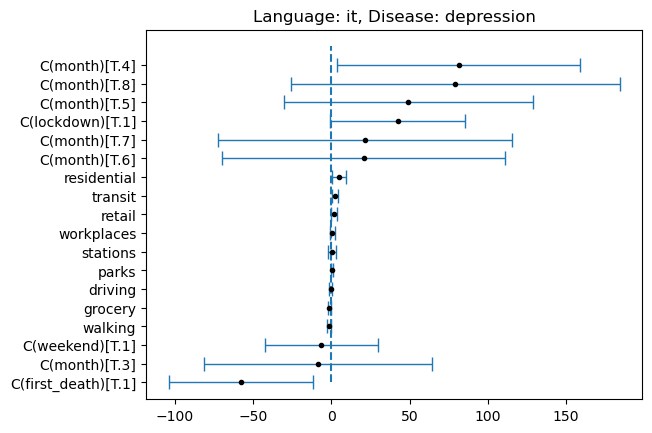

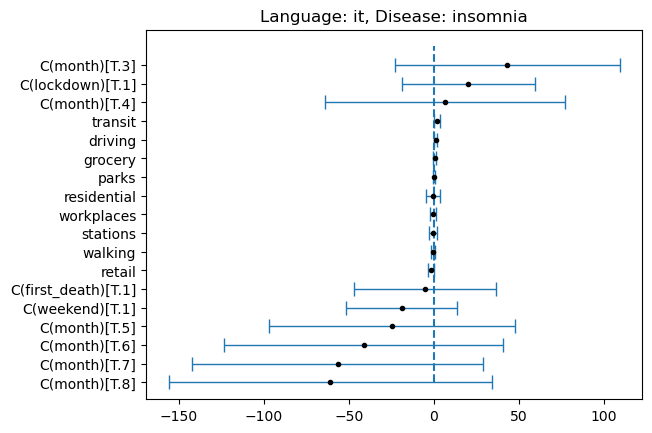

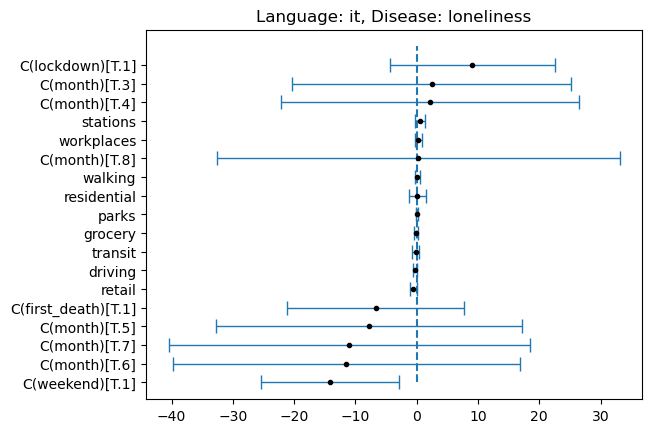

In [38]:
for lang in LANGUAGES:
    for disease_idx in range(4):
        if(lang == 'nl'):
            res = nl_reg_res[disease_idx]
        elif(lang == 'sv'):
            res = sv_reg_res[disease_idx]
        elif(lang == 'pl'):
            res = pl_reg_res[disease_idx]
        elif(lang == 'it'):
            res = it_reg_res[disease_idx]
        
        visualise_effect_of_predictors(res, lang, disease_idx)